# Troubleshoot too-good ML results with no game features

In [1]:
## Startup:

import synapseclient
from synapseclient import Project, Folder, File
import pandas as pd
import json
import pickle
import re
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import numpy as np
import seaborn as sns
import os
from numpy import nan
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import ranksums
%load_ext autoreload
%autoreload 2
%matplotlib inline  


## set options ##

sns.set(style="darkgrid", color_codes=True, font_scale=1.5)

# so i can see all rows of dfs
pd.set_option('display.max_columns', 500)

# so that i can print as many lines as i want
np.set_printoptions(threshold='nan') 

## import my memorytools module ##

import memorytools as mt


# Load up the memory & demographic data:

# initialize environment:
synuser = os.environ['SYNAPSE_USER']
synpass = os.environ['SYNAPSE_PASS']
mt.loadSynapseRecordsFromScratch = False
syn, memory, memorysyn, filePaths, demographics, demosyn, data = mt.create_memory_environment(synuser, synpass)
data = mt.filter_data_for_popular_phones(data)

# pull out features from games:
fromFile = True#False
toSave = False#True
data = mt.add_memory_game_features_to_data(filePaths, data, fromFile = fromFile, toSave=toSave, outFileName='memory_data_with_features.p')

# add memory composite features:
data = mt.add_composite_features_to_data(data)


from sklearn import linear_model
import sklearn
import sklearn.linear_model
import sklearn.cross_validation
import sklearn.tree
import sklearn.ensemble
import numpy as np
from sklearn.utils.validation import check_consistent_length, _num_samples
import sklearn.preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# load feature categories
fcats = mt.define_feature_categories()


Welcome, Matthew Oberhardt!
(phones are now filtered for only the most popular ones)
memory features loaded from file: memory_data_with_features.p (input data was ignored)
Note that nyearsOffMeds = nyearsParkinsons - nyearsOnMeds
Note that nyearsOffMeds = nyearsParkinsons - nyearsOnMeds


In [2]:
from memorytools import *
agecutoff = 45

# Works too well here:

['hasParkinsons', 'age', 'education', 'phoneInfo']
Features converted to numbers:

['phoneInfo', 'education']
dropped 19 rows to remove all nas from data
na rows have been dropped (if there were any)


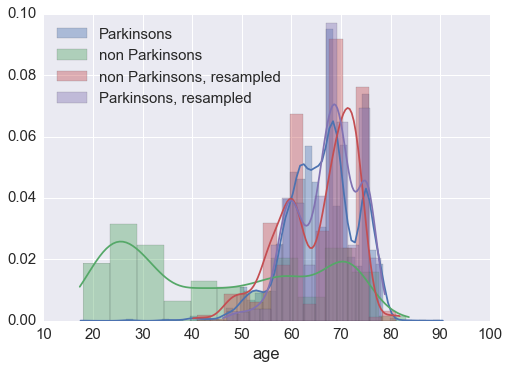

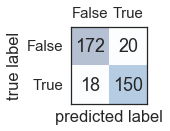



ranksum pval for dist. resampling = 0.326192618887
ranksum pval for sample balanced = 0.000902486196442


num actual positives = 600
num actual negatives = 600


###### performance #######
precision: 0.882352941176
recall: 0.892857142857
F1: 0.887573964497
training accuracy: 0.933333333333
test accuracy: 0.894444444444
random accuracy would be 0.5
##########################


[u'age' u'education' u'phoneInfo']


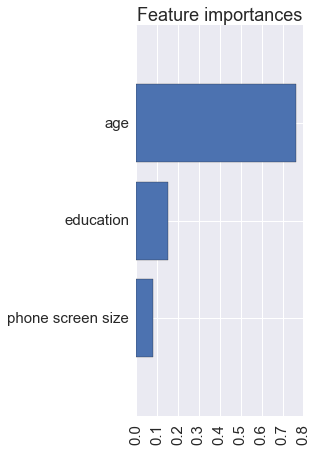

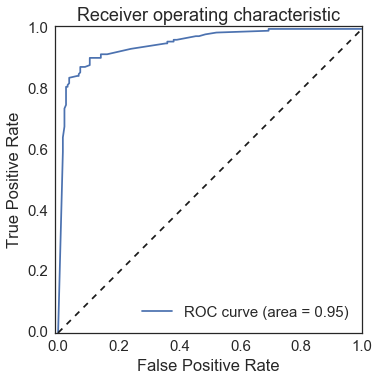

In [57]:
# Run without any of the in-game features
#features = fcats['game'] + ['hasParkinsons'] + fcats['demographic'] + fcats['phone']
features =                  ['hasParkinsons'] + fcats['demographic'] + fcats['phone']
features.remove('smartphone')
features.remove('gender')
print features
MLexcludecols = []
labelcol = 'hasParkinsons'
outs = mt.build_ML_model_age_corrected_and_samplebalanced(data, features, labelcol, toPlot=[0,0,1,1,1,1], toPrint=True, MLexcludecols=MLexcludecols)    
mod, features_df, X, y, X_names, y_name, X_train, X_test, y_train, y_test, train_acc, test_acc, rand_acc, y_pred, y_pred_proba, fdf = outs
print X_names

# Hypothesis: random forest is using ages (& other) as identifiers, since there are repeated vals per user
    
    

## 1. randomize the hasParkinsons labels

['hasParkinsons', 'age', 'education', 'phoneInfo']
  hasParkinsons  age
0         False   43
1         False   43
2         False   73
3         False   73
4         False   73
  hasParkinsons  age
0         False   43
1          True   43
2          True   73
3          True   73
4         False   73
Features converted to numbers:

['phoneInfo', 'education']
dropped 19 rows to remove all nas from data
na rows have been dropped (if there were any)


ranksum pval for dist. resampling = 6.71614729996e-09
ranksum pval for sample balanced = 0.269756455521


num actual positives = 600
num actual negatives = 600


###### performance #######
precision: 0.463636363636
recall: 0.607142857143
F1: 0.525773195876
training accuracy: 0.517857142857
test accuracy: 0.488888888889
random accuracy would be 0.5
##########################


[u'phoneInfo']
run on all data, after removing young folks:
removing the young folks:
(7835, 4)
(6934, 4)
na rows have been dropped (if there were any)


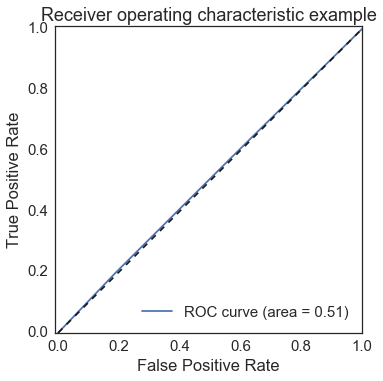

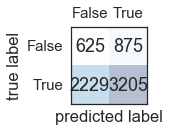

num actual positives = 5434
num actual negatives = 1500


###### performance #######
precision: 0.785539215686
recall: 0.58980493191
F1: 0.673743956275
##########################


shape of X is:  (6934, 1)


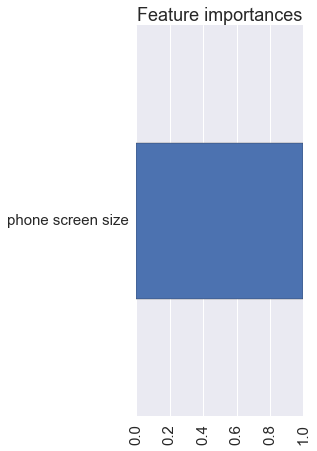

In [4]:
# Run without any of the in-game features
#features = fcats['game'] + ['hasParkinsons'] + fcats['demographic'] + fcats['phone']
features =                  ['hasParkinsons'] + fcats['demographic'] + fcats['phone']
features.remove('smartphone')
features.remove('gender')
print features
MLexcludecols = ['age', 'education']
labelcol = 'hasParkinsons'

# randomly shuffle the hasParkinsons column:
data2 = data.copy()
datajunk = data.copy()
datajunk.index = np.random.permutation(datajunk.index)
data2['hasParkinsons'] = datajunk['hasParkinsons']
print data[['hasParkinsons','age']].head(5)
print data2[['hasParkinsons','age']].head(5)

outs = mt.build_ML_model_age_corrected_and_samplebalanced(data2, features, labelcol, toPlot=[0,0,0,0,0,0], toPrint=True, MLexcludecols=MLexcludecols)    
mod, features_df, X, y, X_names, y_name, X_train, X_test, y_train, y_test, train_acc, test_acc, rand_acc, y_pred, y_pred_proba, fdf = outs
print X_names


# try running on all data:
print 'run on all data, after removing young folks:'
print 'removing the young folks:'

print fdf.shape
fdf = fdf[fdf['age']>agecutoff]
print fdf.shape


features_df, X_all, y_all, _X_names, _y_name, _X_train, _X_test, _y_train, _y_test = mt.prep_memory_features_for_machine_learning(fdf, features, labelcol, convert_features_to_nums=False, toStandardScale=False)

# shuffle vals:
#np.random.shuffle(X_all)


y_pred_proba_all = mod.predict_proba(X_all)[:,1]
y_pred_all = mod.predict(X_all)

mt.plot_roc_curve(y_all, y_pred_proba_all)
mt.render_confusion_matrix(y_all, y_pred_all)
mt.plot_feature_importances_randforest(mod, X_names)
len(X_all)
#print y_pred_proba_all

# print:
precision = sklearn.metrics.precision_score(y_true=y_all, y_pred=y_pred_all)
recall = sklearn.metrics.recall_score(y_true=y_all, y_pred=y_pred_all)
F1 = sklearn.metrics.f1_score(y_true=y_all, y_pred=y_pred_all)
print 'num actual positives = %s' % sum(y_all)
print 'num actual negatives = %s' % (len(y_all) - sum(y_all))
print '\n'
print '###### performance #######'
print 'precision:', precision
print 'recall:', recall
print 'F1:', F1
print '##########################'
print '\n'


print 'shape of X is: ', X_all.shape

## 2. take mean (later - for now, a single sample) of all features for each patient to remove duplicate entries

['hasParkinsons', 'age', 'education', 'phoneInfo']
Features converted to numbers:

['phoneInfo', 'education']
dropped 0 rows to remove all nas from data
na rows have been dropped (if there were any)


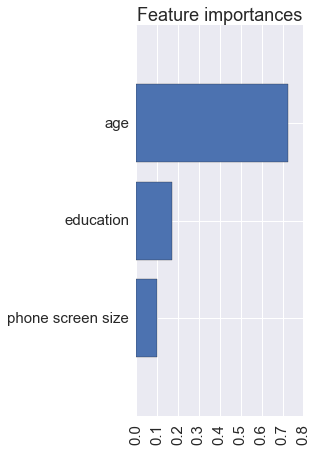

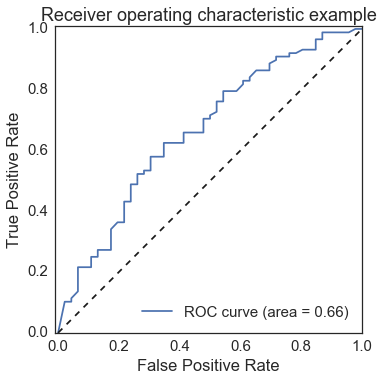

num actual positives = 302
num actual negatives = 143


###### performance #######
precision: 0.785539215686
recall: 0.58980493191
F1: 0.673743956275
training accuracy: 0.517857142857
test accuracy: 0.488888888889
random accuracy would be 0.5
##########################




In [5]:
# take only one record per patient to remove duplicates. mean is better, but that's later..

features =                  ['hasParkinsons'] + fcats['demographic'] + fcats['phone']
features.remove('smartphone')
features.remove('gender')
print features
MLexcludecols = []
labelcol = 'hasParkinsons'

# redo data so i take 1 sample of each patient.
grouped = data.groupby('healthCode')
data2 = grouped.apply(lambda x: x.sample(n=1))
# remove young patients:
data2 = data2[data2['age']>agecutoff]
#outs = mt.build_ML_model_age_corrected_and_samplebalanced(data2, features, labelcol, toPlot=[0,0,0,0,0,0], toPrint=True, MLexcludecols=MLexcludecols)    
######################################################################
######################################################################

#df = data
convert_features_to_nums=False
toStandardScale=False
toPlot=[0,0,0,0,1,1]
toPrint=True


distcol = 'age'
splitcol = 'hasParkinsons'
nbins = 10
nResamples = 600

# build features dataframe:
#fdf = data[features]
fdf = data2[features]
fdf = convert_features_to_numbers(fdf)

# drop nas:
len1 = len(fdf)
fdf = fdf.dropna()
len2 = len(fdf)
print 'dropped %s rows to remove all nas from data' % (len1 - len2)


### Redo machine learning with these sets:
#df = df_resampled_np.append(df_resampled_Park)
df = fdf

# remove cols to exclude from ML (but that were needed for processing)
if len(MLexcludecols) > 0:
    for col in MLexcludecols:
        df = df.drop(col, axis=1)
        features.remove(col)

######### Machine learning #########

features_df, X, y, X_names, y_name, X_train, X_test, y_train, y_test = prep_memory_features_for_machine_learning(df, features, labelcol, convert_features_to_nums=False, toStandardScale=False)

# create model:
mod = RandomForestClassifier(n_estimators=100)
#lr = linear_model.LogisticRegression(penalty='l1', C=0.1) # with regularization
mod.fit(X_train, y_train)

# Probabilities predicted for test set to be in + class:
y_pred_proba = mod.predict_proba(X_test)[:,1]

#  Confusion matrix:
y_pred = mod.predict(X_test)
#    sklearn.metrics.roc_auc_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)


######### Plotting & outputs #########

if toPlot[0] == 1:

    # plot zeroth set:
    plt.figure()
    sns.distplot(df_Parkinsons[distcol].dropna(), label='Parkinsons')
    sns.distplot(df_np[distcol].dropna(), label='non Parkinsons')
    plt.legend(loc=2)
    plt.show()

if toPlot[1] == 1:
    # plot first set:
    plt.figure()
    sns.distplot(df_Parkinsons[distcol].dropna(), label='Parkinsons')
    sns.distplot(df_np[distcol].dropna(), label='non Parkinsons')
    sns.distplot(df_resampled_np[distcol].dropna(), label='non Parkinsons, resampled')
    plt.legend(loc=2)
    plt.show()

if toPlot[2] == 1:
# plot second set:
    plt.figure()
    sns.distplot(df_Parkinsons[distcol].dropna(), label='Parkinsons')
    sns.distplot(df_np[distcol].dropna(), label='non Parkinsons')
    sns.distplot(df_resampled_np[distcol].dropna(), label='non Parkinsons, resampled')
    sns.distplot(df_resampled_Park[distcol].dropna(), label='Parkinsons, resampled')
    plt.legend(loc=2)
    plt.show()

if toPlot[3] == 1:
    render_confusion_matrix(y_test, y_pred)

if toPlot[4] == 1:
    plot_feature_importances_randforest(mod, X_names)

if toPlot[5] == 1:
    plot_roc_curve(y_test, y_pred_proba)

if toPrint == True:
    # test pvals 1st and 2nd set:
    print 'num actual positives = %s' % sum(y)
    print 'num actual negatives = %s' % (len(y) - sum(y))
    print '\n'
    print '###### performance #######'
    print 'precision:', precision
    print 'recall:', recall
    print 'F1:', F1
    print 'training accuracy:', train_acc
    print 'test accuracy:', test_acc
    print 'random accuracy would be %s' % rand_acc
    print '##########################'
    print '\n'

######################################################################
######################################################################




## good, doesn't work. Now, add back in game score:

['game_score', 'hasParkinsons', 'age', 'education', 'phoneInfo']
Features converted to numbers:

['phoneInfo', 'education']
dropped 0 rows to remove all nas from data
na rows have been dropped (if there were any)


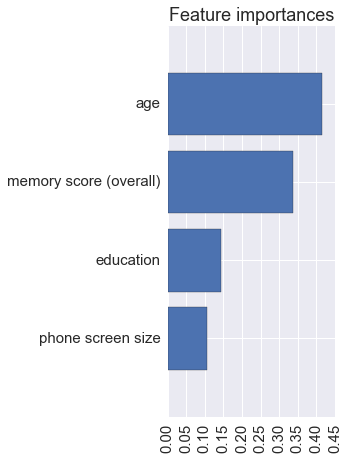

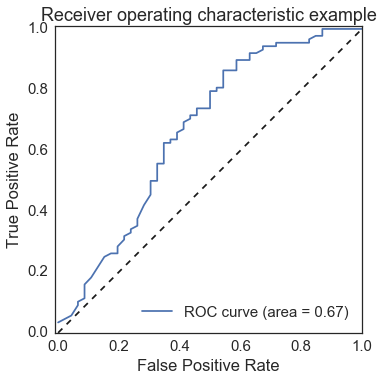

num actual positives = 302
num actual negatives = 143


###### performance #######
precision: 0.785539215686
recall: 0.58980493191
F1: 0.673743956275
training accuracy: 0.517857142857
test accuracy: 0.488888888889
random accuracy would be 0.5
##########################




In [6]:
# take only one record per patient to remove duplicates. mean is better, but that's later..

features = ['game_score'] + ['hasParkinsons'] + fcats['demographic'] + fcats['phone']
features.remove('smartphone')
features.remove('gender')
print features
MLexcludecols = []
labelcol = 'hasParkinsons'

# redo data so i take 1 sample of each patient.
grouped = data.groupby('healthCode')
data2 = grouped.apply(lambda x: x.sample(n=1))
# remove young patients:
data2 = data2[data2['age']>agecutoff]
#outs = mt.build_ML_model_age_corrected_and_samplebalanced(data2, features, labelcol, toPlot=[0,0,0,0,0,0], toPrint=True, MLexcludecols=MLexcludecols)    
######################################################################
######################################################################

#df = data
convert_features_to_nums=False
toStandardScale=False
toPlot=[0,0,0,0,1,1]
toPrint=True


distcol = 'age'
splitcol = 'hasParkinsons'
nbins = 10
nResamples = 600

# build features dataframe:
#fdf = data[features]
fdf = data2[features]
fdf = convert_features_to_numbers(fdf)

# drop nas:
len1 = len(fdf)
fdf = fdf.dropna()
len2 = len(fdf)
print 'dropped %s rows to remove all nas from data' % (len1 - len2)



## resample non-Park to same age distribution as Parkinsons:
#splitVal_resample = False
#splitVal_guide = True
#
#df_resampled, df_guide, df_resample = resample_to_match_distribution(fdf, distcol, splitcol, splitVal_resample, splitVal_guide, nbins, nResamples)
#df_resampled_np = df_resampled
#df_Parkinsons = df_guide
#df_np = df_resample
#
## test pval first set:
#a = df_resampled[distcol].dropna().values
#b = df_guide[distcol].dropna().values
#p1 = ranksums(a, b)
#
## resample Park to the resampled non-Park for sample balancing:
#fdf2 = df_resampled_np.append(df_Parkinsons)
#
#splitVal_resample = True
#splitVal_guide = False
#df_resampled, df_guide, df_resample = resample_to_match_distribution(fdf2, distcol, splitcol, splitVal_resample, splitVal_guide, nbins, nResamples)
#df_resampled_Park = df_resampled
#
## test pval 2nd set:
#a = df_resampled_np[distcol].dropna().values
#b = df_resampled_Park[distcol].dropna().values
#p2 = ranksums(a, b)


### Redo machine learning with these sets:
#df = df_resampled_np.append(df_resampled_Park)
df = fdf

# remove cols to exclude from ML (but that were needed for processing)
if len(MLexcludecols) > 0:
    for col in MLexcludecols:
        df = df.drop(col, axis=1)
        features.remove(col)

######### Machine learning #########

features_df, X, y, X_names, y_name, X_train, X_test, y_train, y_test = prep_memory_features_for_machine_learning(df, features, labelcol, convert_features_to_nums=False, toStandardScale=False)

# create model:
mod = RandomForestClassifier(n_estimators=100)
#lr = linear_model.LogisticRegression(penalty='l1', C=0.1) # with regularization
mod.fit(X_train, y_train)

# Probabilities predicted for test set to be in + class:
y_pred_proba = mod.predict_proba(X_test)[:,1]

#  Confusion matrix:
y_pred = mod.predict(X_test)
#    sklearn.metrics.roc_auc_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)


######### Plotting & outputs #########

if toPlot[0] == 1:

    # plot zeroth set:
    plt.figure()
    sns.distplot(df_Parkinsons[distcol].dropna(), label='Parkinsons')
    sns.distplot(df_np[distcol].dropna(), label='non Parkinsons')
    plt.legend(loc=2)
    plt.show()

if toPlot[1] == 1:
    # plot first set:
    plt.figure()
    sns.distplot(df_Parkinsons[distcol].dropna(), label='Parkinsons')
    sns.distplot(df_np[distcol].dropna(), label='non Parkinsons')
    sns.distplot(df_resampled_np[distcol].dropna(), label='non Parkinsons, resampled')
    plt.legend(loc=2)
    plt.show()

if toPlot[2] == 1:
# plot second set:
    plt.figure()
    sns.distplot(df_Parkinsons[distcol].dropna(), label='Parkinsons')
    sns.distplot(df_np[distcol].dropna(), label='non Parkinsons')
    sns.distplot(df_resampled_np[distcol].dropna(), label='non Parkinsons, resampled')
    sns.distplot(df_resampled_Park[distcol].dropna(), label='Parkinsons, resampled')
    plt.legend(loc=2)
    plt.show()

if toPlot[3] == 1:
    render_confusion_matrix(y_test, y_pred)

if toPlot[4] == 1:
    plot_feature_importances_randforest(mod, X_names)

if toPlot[5] == 1:
    plot_roc_curve(y_test, y_pred_proba)

if toPrint == True:
    # test pvals 1st and 2nd set:
    print 'num actual positives = %s' % sum(y)
    print 'num actual negatives = %s' % (len(y) - sum(y))
    print '\n'
    print '###### performance #######'
    print 'precision:', precision
    print 'recall:', recall
    print 'F1:', F1
    print 'training accuracy:', train_acc
    print 'test accuracy:', test_acc
    print 'random accuracy would be %s' % rand_acc
    print '##########################'
    print '\n'

######################################################################
######################################################################







## Now add in other memory game components and see how we do

['game_numFails', 'game_score', 'game_numGames', '9_numsuccesses', '9_numunsuccesses', '9_meandist', '9_successful', '9_gamescore', '9_latency', '9_firstdist', '9_meanDt', '9_meansuccessfuldist', '16_firstdist', '16_meandist', '16_numsuccesses', '16_gamescore', '16_latency', '16_numunsuccesses', '16_successful', '16_meanDt', '16_meansuccessfuldist', 'played_game4', 'hasParkinsons', 'age', 'education', 'phoneInfo']
Features converted to numbers:

['phoneInfo', 'education']
dropped 30 rows to remove all nas from data
na rows have been dropped (if there were any)


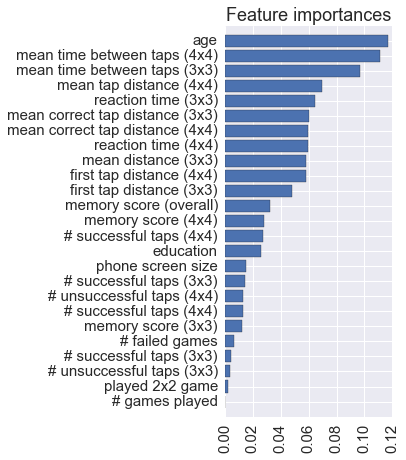

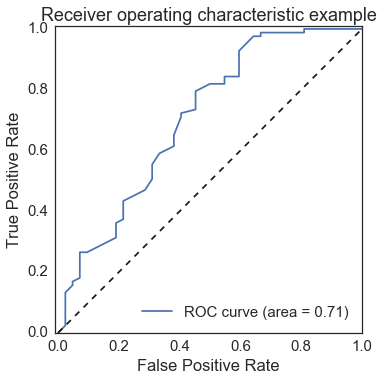

num actual positives = 276
num actual negatives = 139


###### performance #######
precision: 0.785539215686
recall: 0.58980493191
F1: 0.673743956275
training accuracy: 0.517857142857
test accuracy: 0.488888888889
random accuracy would be 0.5
##########################




In [7]:
# take only one record per patient to remove duplicates. mean is better, but that's later..

#features = ['9_meanDt'] + ['hasParkinsons'] + fcats['demographic'] + fcats['phone']
features = fcats['game'] + ['hasParkinsons'] + fcats['demographic'] + fcats['phone']
features.remove('smartphone')
features.remove('gender')
print features
MLexcludecols = []
labelcol = 'hasParkinsons'

# redo data so i take 1 sample of each patient.
grouped = data.groupby('healthCode')
data2 = grouped.apply(lambda x: x.sample(n=1))
# remove young patients:
data2 = data2[data2['age']>agecutoff]
#outs = mt.build_ML_model_age_corrected_and_samplebalanced(data2, features, labelcol, toPlot=[0,0,0,0,0,0], toPrint=True, MLexcludecols=MLexcludecols)    
######################################################################
######################################################################

#df = data
convert_features_to_nums=False
toStandardScale=False
toPlot=[0,0,0,0,1,1]
toPrint=True


distcol = 'age'
splitcol = 'hasParkinsons'
nbins = 10
nResamples = 600

# build features dataframe:
#fdf = data[features]
fdf = data2[features]
fdf = convert_features_to_numbers(fdf)

# drop nas:
len1 = len(fdf)
fdf = fdf.dropna()
len2 = len(fdf)
print 'dropped %s rows to remove all nas from data' % (len1 - len2)




### Redo machine learning with these sets:
#df = df_resampled_np.append(df_resampled_Park)
df = fdf

# remove cols to exclude from ML (but that were needed for processing)
if len(MLexcludecols) > 0:
    for col in MLexcludecols:
        df = df.drop(col, axis=1)
        features.remove(col)

######### Machine learning #########

features_df, X, y, X_names, y_name, X_train, X_test, y_train, y_test = prep_memory_features_for_machine_learning(df, features, labelcol, convert_features_to_nums=False, toStandardScale=False)

# create model:
mod = RandomForestClassifier(n_estimators=100)
#lr = linear_model.LogisticRegression(penalty='l1', C=0.1) # with regularization
mod.fit(X_train, y_train)

# Probabilities predicted for test set to be in + class:
y_pred_proba = mod.predict_proba(X_test)[:,1]

#  Confusion matrix:
y_pred = mod.predict(X_test)
#    sklearn.metrics.roc_auc_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)


######### Plotting & outputs #########

if toPlot[0] == 1:

    # plot zeroth set:
    plt.figure()
    sns.distplot(df_Parkinsons[distcol].dropna(), label='Parkinsons')
    sns.distplot(df_np[distcol].dropna(), label='non Parkinsons')
    plt.legend(loc=2)
    plt.show()

if toPlot[1] == 1:
    # plot first set:
    plt.figure()
    sns.distplot(df_Parkinsons[distcol].dropna(), label='Parkinsons')
    sns.distplot(df_np[distcol].dropna(), label='non Parkinsons')
    sns.distplot(df_resampled_np[distcol].dropna(), label='non Parkinsons, resampled')
    plt.legend(loc=2)
    plt.show()

if toPlot[2] == 1:
# plot second set:
    plt.figure()
    sns.distplot(df_Parkinsons[distcol].dropna(), label='Parkinsons')
    sns.distplot(df_np[distcol].dropna(), label='non Parkinsons')
    sns.distplot(df_resampled_np[distcol].dropna(), label='non Parkinsons, resampled')
    sns.distplot(df_resampled_Park[distcol].dropna(), label='Parkinsons, resampled')
    plt.legend(loc=2)
    plt.show()

if toPlot[3] == 1:
    render_confusion_matrix(y_test, y_pred)

if toPlot[4] == 1:
    plot_feature_importances_randforest(mod, X_names)

if toPlot[5] == 1:
    plot_roc_curve(y_test, y_pred_proba)

if toPrint == True:
    # test pvals 1st and 2nd set:
    print 'num actual positives = %s' % sum(y)
    print 'num actual negatives = %s' % (len(y) - sum(y))
    print '\n'
    print '###### performance #######'
    print 'precision:', precision
    print 'recall:', recall
    print 'F1:', F1
    print 'training accuracy:', train_acc
    print 'test accuracy:', test_acc
    print 'random accuracy would be %s' % rand_acc
    print '##########################'
    print '\n'

######################################################################
######################################################################






In [8]:
# that worked..

## Run same test as above with simplified code (one sample per patient, all features):

['game_numFails', 'game_score', 'game_numGames', '9_numsuccesses', '9_numunsuccesses', '9_meandist', '9_successful', '9_gamescore', '9_latency', '9_firstdist', '9_meanDt', '9_meansuccessfuldist', '16_firstdist', '16_meandist', '16_numsuccesses', '16_gamescore', '16_latency', '16_numunsuccesses', '16_successful', '16_meanDt', '16_meansuccessfuldist', 'played_game4', 'hasParkinsons', 'age', 'education', 'phoneInfo']
Features converted to numbers:

['phoneInfo', 'education']
dropped 27 rows to remove all nas from data
na rows have been dropped (if there were any)
[ 0.00657385  0.03256489  0.00160024  0.00786213  0.00444161  0.05870525
  0.00176907  0.00914297  0.05160626  0.05562062  0.10523487  0.05726085
  0.05422104  0.08400176  0.03095981  0.02868182  0.05938533  0.01213106
  0.0099258   0.10647735  0.06762065  0.0016065   0.11770669  0.01629002
  0.01860955]


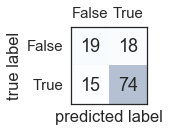



num actual positives = 279
num actual negatives = 139


###### performance #######
precision: 0.804347826087
recall: 0.831460674157
F1: 0.817679558011
training accuracy: 1.0
test accuracy: 0.738095238095
random accuracy would be 0.667464114833
##########################




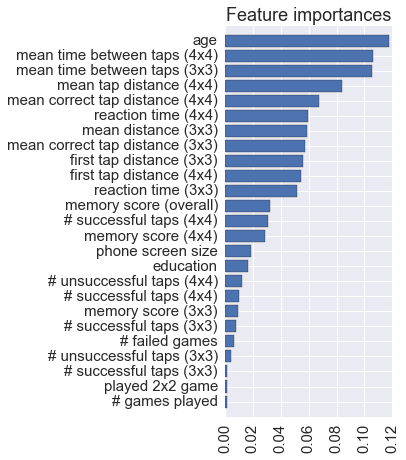

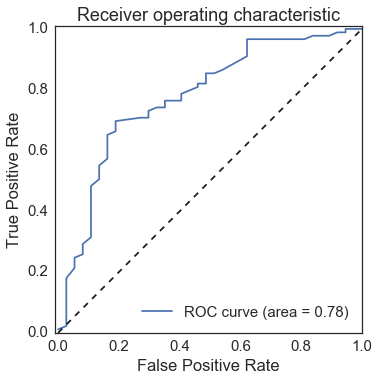

In [73]:
# simplified code when not sample balancing:
# (with other memory features)

# take only one record per patient to remove duplicates. mean is better, but that's later..

features = fcats['game'] + ['hasParkinsons'] + fcats['demographic'] + fcats['phone']
features.remove('smartphone')
features.remove('gender')
print features
MLexcludecols = []
labelcol = 'hasParkinsons'

# redo data so i take 1 sample of each patient.
grouped = data.groupby('healthCode')
datasample = grouped.apply(lambda x: x.sample(n=1))
# remove young patients:
datasample = datasample[datasample['age']>agecutoff]

outs = mt.build_ML_model(datasample, features, labelcol=labelcol, toPlot=[1,1,1], toPrint=True, MLexcludecols=MLexcludecols)
model, fdf, X, y, X_names, y_name, X_train, X_test, y_train, y_test, train_acc, test_acc, rand_acc, y_pred, y_pred_proba = outs   




## mean values per patient, all features:

Features converted to numbers:

['phoneInfo', 'education']
dropped 256 rows to remove all nas from data
# left in labelcol:  290.0
# total in labelcol:  430
na rows have been dropped (if there were any)


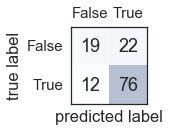



num actual positives = 290.0
num actual negatives = 140.0


###### performance #######
precision: 0.775510204082
recall: 0.863636363636
F1: 0.817204301075
training accuracy: 1.0
test accuracy: 0.736434108527
random accuracy would be 0.674418604651
##########################




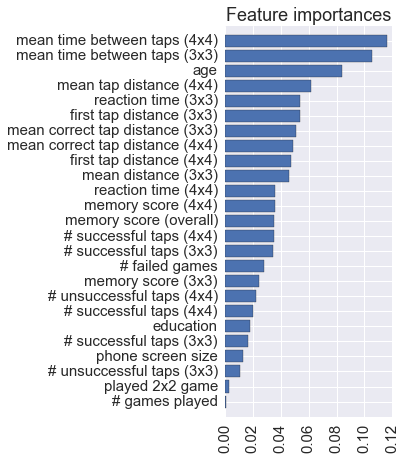

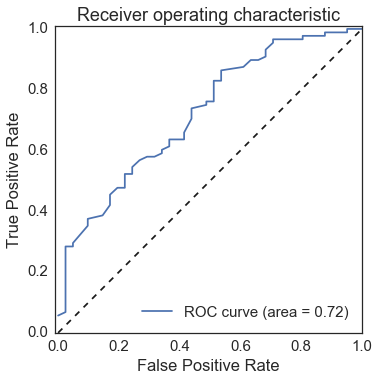

In [56]:
# simplified code when not sample balancing:
# (with other memory features)

# take only one record per patient to remove duplicates. mean is better, but that's later..

features = fcats['game'] + ['hasParkinsons'] + fcats['demographic'] + fcats['phone'] + ['healthCode']
features.remove('smartphone')
features.remove('gender')
#print features
featureToMean = ['healthCode'] # don't need to also exclude - this step takes care of that too.
MLexcludecols = []
labelcol = 'hasParkinsons'

# redo data so i take 1 sample of each patient.
#grouped = data.groupby('healthCode')
#datasample = grouped.apply(lambda x: x.sample(n=1))
# remove young patients:
datasample = data[data['age']>agecutoff]

outs = mt.build_ML_model(datasample, features, labelcol=labelcol, toPlot=[1,1,1], toPrint=True, MLexcludecols=MLexcludecols, modelType='randomforest', featureToMean=featureToMean)
model, fdf, X, y, X_names, y_name, X_train, X_test, y_train, y_test, train_acc, test_acc, rand_acc, y_pred, y_pred_proba = outs   





## mean values per patient, all features except age

Features converted to numbers:

['phoneInfo', 'education']
dropped 256 rows to remove all nas from data
# left in labelcol:  290.0
# total in labelcol:  430
na rows have been dropped (if there were any)


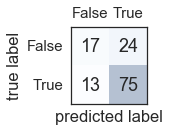



num actual positives = 290.0
num actual negatives = 140.0


###### performance #######
precision: 0.757575757576
recall: 0.852272727273
F1: 0.802139037433
training accuracy: 1.0
test accuracy: 0.713178294574
random accuracy would be 0.674418604651
##########################




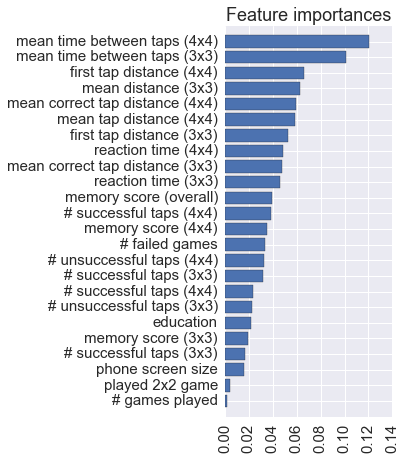

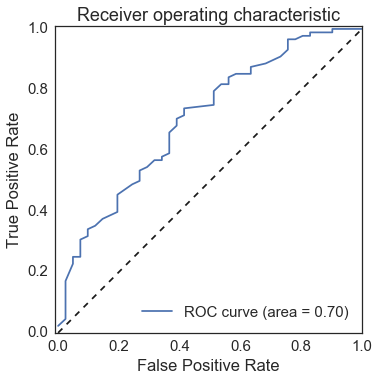

In [55]:
# simplified code when not sample balancing:
# (with other memory features)

# take only one record per patient to remove duplicates. mean is better, but that's later..

features = fcats['game'] + ['hasParkinsons'] + fcats['demographic'] + fcats['phone'] + ['healthCode']
features.remove('smartphone')
features.remove('gender')
features.remove('age')
#print features
featureToMean = ['healthCode'] # don't need to also exclude - this step takes care of that too.
MLexcludecols = []
labelcol = 'hasParkinsons'

# redo data so i take 1 sample of each patient.
#grouped = data.groupby('healthCode')
#datasample = grouped.apply(lambda x: x.sample(n=1))
# remove young patients:
datasample = data[data['age']>agecutoff]

outs = mt.build_ML_model(datasample, features, labelcol=labelcol, toPlot=[1,1,1], toPrint=True, MLexcludecols=MLexcludecols, modelType='randomforest', featureToMean=featureToMean)
model, fdf, X, y, X_names, y_name, X_train, X_test, y_train, y_test, train_acc, test_acc, rand_acc, y_pred, y_pred_proba = outs   



## mean values per patient, only demographic features

Features converted to numbers:

['phoneInfo', 'education']
dropped 0 rows to remove all nas from data
na rows have been dropped (if there were any)


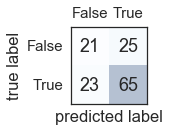

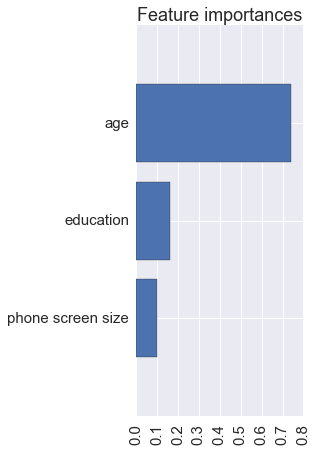

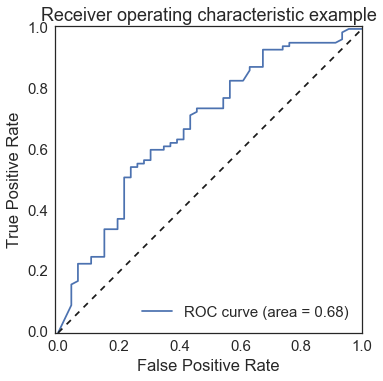



num actual positives = 302.0
num actual negatives = 143.0


###### performance #######
precision: 0.722222222222
recall: 0.738636363636
F1: 0.730337078652
training accuracy: 0.890675241158
test accuracy: 0.641791044776
random accuracy would be 0.678651685393
##########################




In [15]:
# simplified code when not sample balancing:
# (with other memory features)

# take only one record per patient to remove duplicates. mean is better, but that's later..

features = ['hasParkinsons'] + fcats['demographic'] + fcats['phone'] + ['healthCode']
features.remove('smartphone')
features.remove('gender')
#print features
featureToMean = ['healthCode'] # don't need to also exclude - this step takes care of that too.
MLexcludecols = []
labelcol = 'hasParkinsons'

# redo data so i take 1 sample of each patient.
#grouped = data.groupby('healthCode')
#datasample = grouped.apply(lambda x: x.sample(n=1))

# remove young patients:
datasample = data[data['age']>agecutoff]

outs = mt.build_ML_model(datasample, features, labelcol=labelcol, toPlot=[1,1,1], toPrint=True, MLexcludecols=MLexcludecols, modelType='randomforest', featureToMean=featureToMean)
model, fdf, X, y, X_names, y_name, X_train, X_test, y_train, y_test, train_acc, test_acc, rand_acc, y_pred, y_pred_proba = outs   




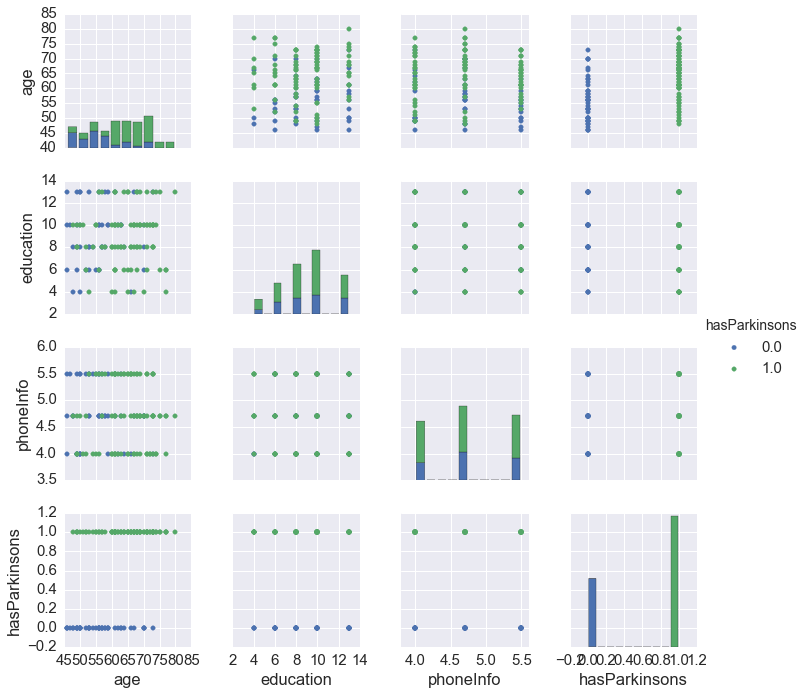

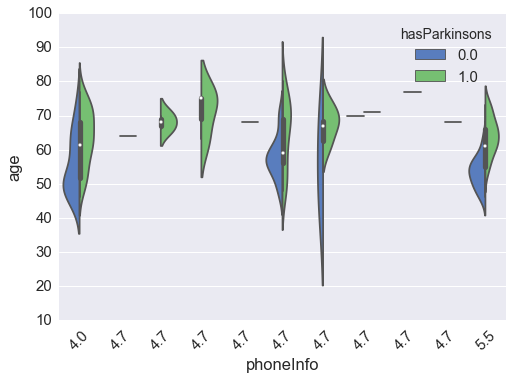

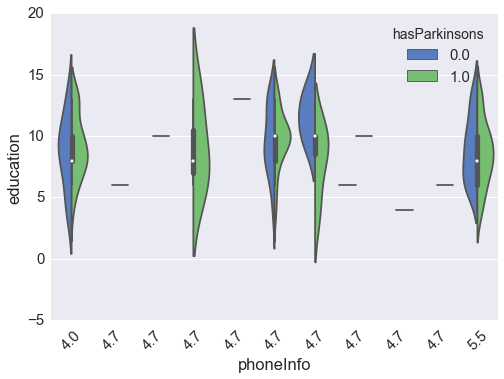

In [12]:
# visualize the feature distributions:
dftest = pd.DataFrame()
for i, name in enumerate(X_names):
    dftest[name] = X_test[:,i]

dftest['hasParkinsons'] = y_test
features_df = dftest

g = sns.PairGrid(features_df, hue="hasParkinsons")
g = g.map_offdiag(plt.scatter)
g = g.map_diag(plt.hist)
g = g.add_legend()

yvar = 'hasParkinsons'
catvars = ['phoneInfo']
freqvars = ['age', 'education']
for freqvar in freqvars:
    for catvar in catvars:
        plt.figure()
        ax1 = sns.violinplot(x=catvar, y=freqvar, hue=yvar, data=features_df, palette="muted", split=True)    
        plt.xticks(rotation=45)

## add back in resampling of non-parkinsons for age, along with means?

Features converted to numbers:

['phoneInfo', 'education']
dropped 0 rows to remove all nas from data
# left in labelcol:  302.0
# total in labelcol:  445
pval for resampling (want nonsignificant):  2.85017692414e-06
na rows have been dropped (if there were any)


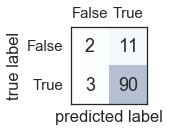

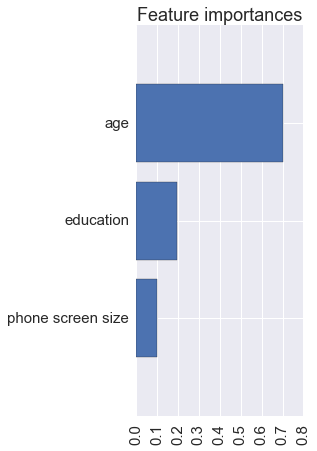

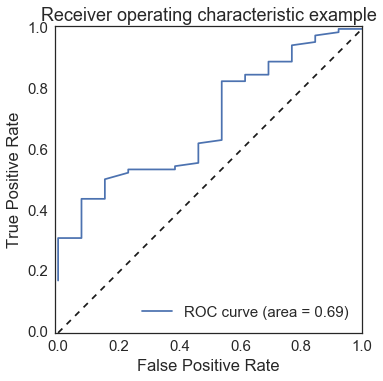



num actual positives = 302.0
num actual negatives = 50.0


###### performance #######
precision: 0.891089108911
recall: 0.967741935484
F1: 0.927835051546
training accuracy: 0.943089430894
test accuracy: 0.867924528302
random accuracy would be 0.857954545455
##########################




In [39]:
# Only demographic features:

# simplified code when not sample balancing:
# (with other memory features)

# take only one record per patient to remove duplicates. mean is better, but that's later..

features = ['hasParkinsons'] + fcats['demographic'] + fcats['phone'] + ['healthCode']
features.remove('smartphone')
features.remove('gender')
#print features
featureToMean = ['healthCode'] # don't need to also exclude - this step takes care of that too.
MLexcludecols = []
labelcol = 'hasParkinsons'

# redo data so i take 1 sample of each patient.
#grouped = data.groupby('healthCode')
#datasample = grouped.apply(lambda x: x.sample(n=1))

# remove young patients:
datasample = data[data['age']>agecutoff]
# 143 non-Parkinsons and 302 Parkinsons left after age cutoff
Params = mt.sampleBalanceDefaultParams
Params['nResamples'] = 50
Params['nbins'] = 5
outs = mt.build_ML_model(datasample, features, labelcol=labelcol, toPlot=[1,1,1], toPrint=True, MLexcludecols=MLexcludecols, modelType='randomforest', featureToMean=featureToMean, sampleBalance=True, sampleBalanceParams=Params)
model, fdf, X, y, X_names, y_name, X_train, X_test, y_train, y_test, train_acc, test_acc, rand_acc, y_pred, y_pred_proba = outs   

# doesn't help.. there are too few samples.


## One sample per patient, all but remove age

Features converted to numbers:

['phoneInfo', 'education']
dropped 28 rows to remove all nas from data
na rows have been dropped (if there were any)


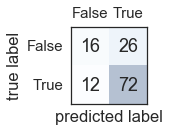

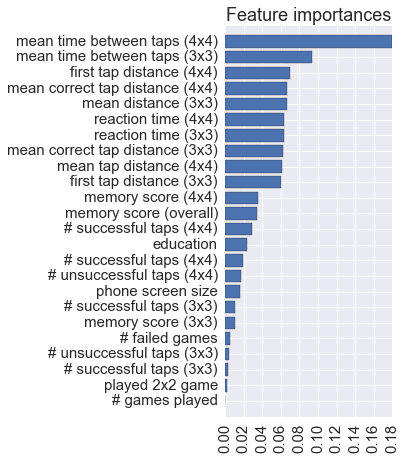

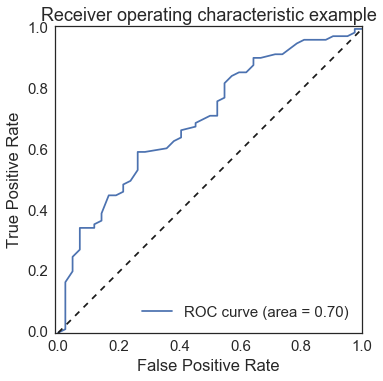



num actual positives = 277
num actual negatives = 140


###### performance #######
precision: 0.734693877551
recall: 0.857142857143
F1: 0.791208791209
training accuracy: 1.0
test accuracy: 0.698412698413
random accuracy would be 0.664268585132
##########################




In [41]:
# simplified code when not sample balancing:
# (with other memory features)
# take only one record per patient to remove duplicates. mean is better, but that's later..

features = fcats['game'] + ['hasParkinsons'] + fcats['demographic'] + fcats['phone']
features.remove('smartphone')
features.remove('gender')
features.remove('age')

MLexcludecols = []
labelcol = 'hasParkinsons'

# redo data so i take 1 sample of each patient.
grouped = data.groupby('healthCode')
datasample = grouped.apply(lambda x: x.sample(n=1))
# remove young patients:
datasample = datasample[datasample['age']>agecutoff]

outs = mt.build_ML_model(datasample, features, labelcol=labelcol, toPlot=[1,1,1], toPrint=True, MLexcludecols=MLexcludecols)
model, fdf, X, y, X_names, y_name, X_train, X_test, y_train, y_test, train_acc, test_acc, rand_acc, y_pred, y_pred_proba = outs   




## One sample per patient, demographic but remove age

Features converted to numbers:

['gender', 'phoneInfo', 'education']
dropped 0 rows to remove all nas from data
na rows have been dropped (if there were any)


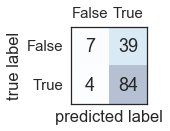

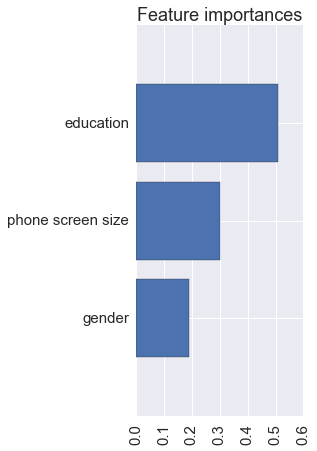

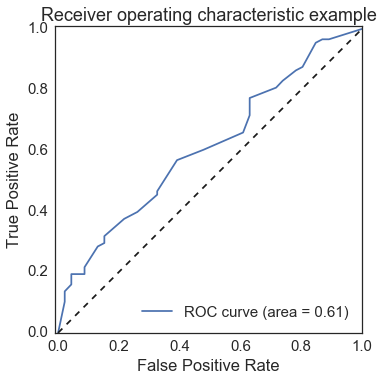



num actual positives = 302
num actual negatives = 143


###### performance #######
precision: 0.682926829268
recall: 0.954545454545
F1: 0.796208530806
training accuracy: 0.710610932476
test accuracy: 0.679104477612
random accuracy would be 0.678651685393
##########################




In [47]:
# simplified code when not sample balancing:
# (with other memory features)
# take only one record per patient to remove duplicates. mean is better, but that's later..

features =  ['hasParkinsons'] + fcats['demographic'] + fcats['phone']
features.remove('smartphone')
#features.remove('gender')
features.remove('age')

MLexcludecols = []
labelcol = 'hasParkinsons'

# redo data so i take 1 sample of each patient.
grouped = data.groupby('healthCode')
datasample = grouped.apply(lambda x: x.sample(n=1))
# remove young patients:
datasample = datasample[datasample['age']>agecutoff]

outs = mt.build_ML_model(datasample, features, labelcol=labelcol, toPlot=[1,1,1], toPrint=True, MLexcludecols=MLexcludecols)
model, fdf, X, y, X_names, y_name, X_train, X_test, y_train, y_test, train_acc, test_acc, rand_acc, y_pred, y_pred_proba = outs   


## One sample per patient, run as a loop (all features, but no age) (will unpack & use for plotting rocs 

In [53]:
# simplified code when not sample balancing:
# (with other memory features)
# take only one record per patient to remove duplicates. mean is better, but that's later..
features = fcats['game'] + ['hasParkinsons'] + fcats['demographic'] + fcats['phone']
features.remove('smartphone')
features.remove('gender')
features.remove('age')
MLexcludecols = []
labelcol = 'hasParkinsons'

# aggregate lists:
models = []
train_accs = []
y_tests = []
y_pred_probas = []

nIters = 10
for iter in range(nIters):
    print 'starting iter ', iter
    # redo data so i take 1 sample of each patient.
    grouped = data.groupby('healthCode')
    datasample = grouped.apply(lambda x: x.sample(n=1))
    # remove young patients:
    datasample = datasample[datasample['age']>agecutoff]
    # run model:
    with suppress_stdout():
        outs = mt.build_ML_model(datasample, features, labelcol=labelcol, toPlot=[0,0,0], toPrint=False, MLexcludecols=MLexcludecols)
    model, fdf, X, y, X_names, y_name, X_train, X_test, y_train, y_test, train_acc, test_acc, rand_acc, y_pred, y_pred_proba = outs   
    # capture results:
    models.append(model)
    train_accs.append(train_acc)
    y_tests.append(y_test)
    y_pred_probas.append(y_pred_proba)
    



starting iter  0
starting iter  1
starting iter  2
starting iter  3
starting iter  4
starting iter  5
starting iter  6
starting iter  7
starting iter  8
starting iter  9


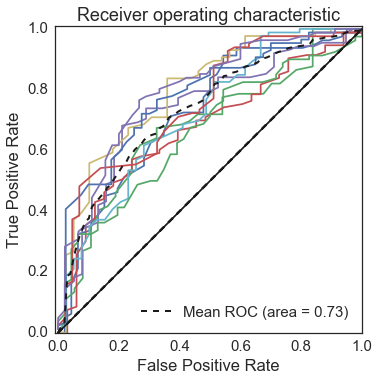

In [54]:
# plot the ROCs:
mt.plot_roc_curves_with_mean(y_tests, y_pred_probas)

## One sample per patient, run as a loop (all features, but no age) (will unpack & use for plotting rocs . Logistic regression

In [68]:
# simplified code when not sample balancing:
# (with other memory features)
# take only one record per patient to remove duplicates. mean is better, but that's later..
features = fcats['game'] + ['hasParkinsons'] + fcats['demographic'] + fcats['phone']
features.remove('smartphone')
features.remove('gender')
features.remove('age')
MLexcludecols = []
labelcol = 'hasParkinsons'

# aggregate lists:
models = []
train_accs = []
y_tests = []
y_pred_probas = []

nIters = 10
for iter in range(nIters):
    print 'starting iter ', iter
    # redo data so i take 1 sample of each patient.
    grouped = data.groupby('healthCode')
    datasample = grouped.apply(lambda x: x.sample(n=1))
    # remove young patients:
    datasample = datasample[datasample['age']>agecutoff]
    # run model:
    with suppress_stdout():
        outs = mt.build_ML_model(datasample, features, labelcol=labelcol, toPlot=[0,0,0], toPrint=False, MLexcludecols=MLexcludecols, modelType='logisticregression')
    model, fdf, X, y, X_names, y_name, X_train, X_test, y_train, y_test, train_acc, test_acc, rand_acc, y_pred, y_pred_proba = outs   
    # capture results:
    models.append(model)
    train_accs.append(train_acc)
    y_tests.append(y_test)
    y_pred_probas.append(y_pred_proba)
    

starting iter  0
starting iter  1
starting iter  2
starting iter  3
starting iter  4
starting iter  5
starting iter  6
starting iter  7
starting iter  8
starting iter  9


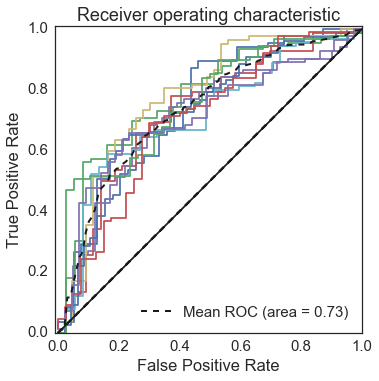

In [69]:
# plot the ROCs:
mt.plot_roc_curves_with_mean(y_tests, y_pred_probas)

Features converted to numbers:

['phoneInfo', 'education']
dropped 256 rows to remove all nas from data
# left in labelcol:  290.0
# total in labelcol:  430
na rows have been dropped (if there were any)
[  4.79083797e-01  -4.43756638e-03  -6.51159050e-01  -2.20015035e-01
   5.82880438e-01   1.29006155e-01  -2.91119814e+00  -2.44452143e-02
  -1.35784581e+00   7.01766465e-03   6.37101776e+00   2.53923653e-02
   2.73364199e-02  -1.69202352e-02  -7.99230392e-01   7.57606268e-02
  -1.93251759e-01   1.03124594e+01   9.42482065e+00   7.96192862e-01
   1.34171414e-01  -2.62287989e+00  -9.82058805e-02  -4.30759133e-01]


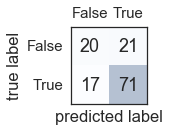



num actual positives = 290.0
num actual negatives = 140.0


###### performance #######
precision: 0.771739130435
recall: 0.806818181818
F1: 0.788888888889
training accuracy: 0.764119601329
test accuracy: 0.705426356589
random accuracy would be 0.674418604651
##########################




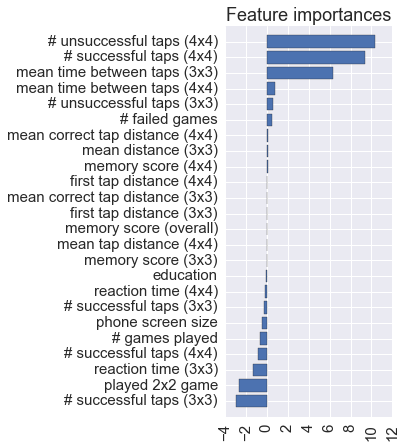

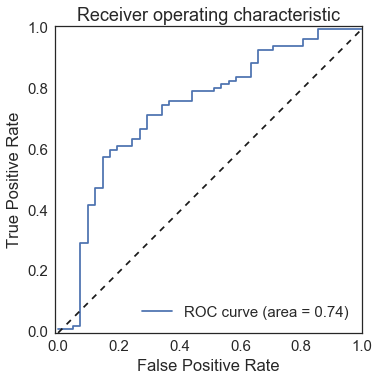

In [79]:
# logistic regression, mean values

# simplified code when not sample balancing:
# (with other memory features)
# take only one record per patient to remove duplicates. mean is better, but that's later..

features = fcats['game'] + ['hasParkinsons'] + fcats['demographic'] + fcats['phone'] + ['healthCode']
features.remove('smartphone')
features.remove('gender')
features.remove('age')
featureToMean = ['healthCode']
MLexcludecols = []
labelcol = 'hasParkinsons'

# remove young patients:
datasample = data[data['age']>agecutoff]

outs = mt.build_ML_model(datasample, features, labelcol=labelcol, toPlot=[1,1,1], toPrint=True, MLexcludecols=MLexcludecols, modelType='logisticregression', featureToMean=featureToMean)
model, fdf, X, y, X_names, y_name, X_train, X_test, y_train, y_test, train_acc, test_acc, rand_acc, y_pred, y_pred_proba = outs   


In [71]:
model.coef_

array([[  5.06172058e-01,  -4.34703884e-03,  -5.23942963e-01,
         -2.07531484e-01,   1.13641375e+00,   1.24165373e-01,
         -2.57835134e+00,  -2.05155013e-02,  -1.35174487e+00,
          6.85097296e-03,   6.38029536e+00,   3.07910379e-02,
          2.78854824e-02,  -2.02633071e-02,  -8.06728225e-01,
          7.62736611e-02,  -1.92679925e-01,   1.07214828e+01,
          9.87001329e+00,   7.93230127e-01,   1.37034454e-01,
         -2.62121925e+00,  -9.88107572e-02,  -4.28598612e-01]])

In [ ]:
# play with the coef, and do l2.. get plot working!

# try logistic regression on all the analyses

## Predict whether meds are working for Parkinson's patients:

In [81]:
# predict has or has not parkinsons:
df_P = data[data['hasParkinsons'] == True]
df_P.head(2)



,recordId,healthCode,createdOn,appVersion,phoneInfo,game_score,game_numGames,game_numFails,game_startDate,game_endDate,game_records,medTimepoint,game_records_txt,recordId_demographic,createdOn_demographic,appVersion_demographic,phoneInfo_demographic,age,isCaretaker,brainStim,diagYear,education,employment,gender,healthHistory,healthcareProvider,homeUsage,lastSmoked,maritalStatus,medicalUsage,medicalUsageYesterday,medicationStartYear,onsetYear,packsPerDay,pastParticipation,phoneUsage,professionalDiagnosis,race,smartphone,smoked,surgery,videoUsage,yearsSmoking,gamesdata,16_latency,16_gamescore,16_successful,16_meanDt,16_meandist,16_gamesize,16_meanunsuccessfuldist,16_meansuccessfuldist,16_numunsuccesses,16_numsuccesses,16_firstdist,9_latency,9_gamescore,9_successful,9_meanDt,9_meandist,9_gamesize,9_meanunsuccessfuldist,9_meansuccessfuldist,9_numunsuccesses,9_numsuccesses,9_firstdist,4_latency,4_gamescore,4_successful,4_meanDt,4_meandist,4_gamesize,4_meanunsuccessfuldist,4_meansuccessfuldist,4_numunsuccesses,4_numsuccesses,4_firstdist,hasParkinsons,played_game4,nyearsParkinsons,nyearsOnMeds,nyearsOffMeds
122,4a6213f1-3fec-45a4-b168-006eb2c6e1fe,c959f434-9f57-4730-b4c1-804789db0a33,1429661507000,"version 1.0.5, build 12",iPhone 6,255,5,2,1429661442000,1429661507000,5584921,Immediately before Parkinson medication,5584921,eec410ae-80da-4698-85e9-acf7b29170d7,1428589288000,"version 1.0, build 7",iPhone 6,43,False,True,2005,4-year college degree,Unable to work,Male,"""Anxiety"",""Depression"",""Obstructive Sleep Apnea""",Parkinson Disease/Movement Disorder Specialist,True,NaN,Married or domestic partnership,True,true,2007,1998,NaN,False,true,True,"""White or Caucasian""",Neither easy nor difficult,False,True,True,NaN,{u'games_by_sizes': {16: [{u'MemoryGameRecordG...,0.916763,50,0.333333,1.006982,10.757069,16,6.732555,11.350988,0.666667,4.000000,11.195531,1.443679,52.5,1,1.012801,12.734278,9,NaN,12.734278,0,3.5,9.882608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,18,9,9
123,bcdcfd20-b417-413c-bc65-90ce7d49710f,c959f434-9f57-4730-b4c1-804789db0a33,1429725498000,"version 1.0.5, build 12",iPhone 6,285,5,1,1429725438000,1429725498000,5696655,Immediately before Parkinson medication,5696655,eec410ae-80da-4698-85e9-acf7b29170d7,1428589288000,"version 1.0, build 7",iPhone 6,43,False,True,2005,4-year college degree,Unable to work,Male,"""Anxiety"",""Depression"",""Obstructive Sleep Apnea""",Parkinson Disease/Movement Disorder Specialist,True,NaN,Married or domestic partnership,True,true,2007,1998,NaN,False,true,True,"""White or Caucasian""",Neither easy nor difficult,False,True,True,NaN,{u'games_by_sizes': {16: [{u'MemoryGameRecordG...,0.953937,60,0.333333,1.005068,23.237983,16,117.442827,11.417147,0.666667,4.333333,12.463610,0.696806,52.5,1,0.954377,11.607255,9,NaN,11.607255,0,3.5,13.780147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,18,9,9


In [82]:
!!!! finish this in the morning.
# logistic regression on all Parkinsons records, classifying 'took meds' vs 'didn't

# simplified code when not sample balancing:
# (with other memory features)
# take only one record per patient to remove duplicates. mean is better, but that's later..

features = fcats['game'] + ['hasParkinsons'] + fcats['demographic'] + fcats['phone'] + ['healthCode']
features.remove('smartphone')
features.remove('gender')
#features.remove('age') # don't remove this here
#featureToMean = ['healthCode']
MLexcludecols = []
labelcol = 'medTimepoint' # hasParkinsons

# remove young patients:

outs = mt.build_ML_model(datasample, features, labelcol=labelcol, toPlot=[1,1,1], toPrint=True, MLexcludecols=MLexcludecols, modelType='logisticregression')
model, fdf, X, y, X_names, y_name, X_train, X_test, y_train, y_test, train_acc, test_acc, rand_acc, y_pred, y_pred_proba = outs   


Features converted to numbers:

['phoneInfo', 'education']
dropped 256 rows to remove all nas from data
na rows have been dropped (if there were any)


KeyError: 'medTimepoint'

In [ ]:
# todo: 
    
## Loop through different users and create ensemble of models
